In [281]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json 
from functools import reduce
import seaborn as sns
# !pip install cartoframes

In [291]:
from cartoframes.viz import *
from shapely.geometry import box
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import Point
from cartoframes.auth import Credentials
from cartoframes.auth import set_default_credentials
from cartoframes import to_carto

In [159]:
credentials={
    'username':'mariana11martz11',
    'api_key':'9177a76bf3f8cb4f8a4aa76785b40665eed8f1fd'}

with open("Data/creds.json", "w") as outfile:
    json.dump(credentials, outfile)



In [160]:
set_default_credentials('Data/creds.json')

# Import Dataset

### 1. Counties Shp File - all the counties in the united states
### 2. Crops - Yield and Production 2020 for Corn and Soybeans
### 3. Facility Locations

In [161]:
pd.set_option('display.max_columns', None)

In [162]:
fp="data/tl_2020_us_county.shp"

In [163]:
counties= gpd.read_file(fp)

In [164]:
# counties.head(50)

In [165]:
sample=counties.iloc[0:10,:]

In [166]:
# sample

In [167]:
counties.shape

(3234, 18)

In [168]:
counties_df=pd.DataFrame(counties)

In [169]:
counties[counties['GEOID']== '40109']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1715,40,109,01101842,40109,Oklahoma,Oklahoma County,06,H1,G4020,416,36420,None,A,1836035445,24720769,+35.5546109,-097.4094007,"POLYGON ((-97.67402 35.60925, -97.67402 35.609..."


In [170]:
random= pd.read_csv('data/indigo_case_study_500_random_buyers.csv')

In [171]:
# crops=pd.read_csv('data/36FD247B-D008-3A99-A53C-EBF28BA486C7.csv')
crops= pd.read_csv('data/25C7E4A4-7C7C-393E-B094-CDFBEAD3AB83.csv')



In [172]:
crops.dtypes


Program              object
Year                  int64
Period               object
Week Ending         float64
Geo Level            object
State                object
State ANSI            int64
Ag District          object
Ag District Code      int64
County               object
County ANSI         float64
Zip Code            float64
Region              float64
watershed_code        int64
Watershed           float64
Commodity            object
Data Item            object
Domain               object
Domain Category      object
Value               float64
CV (%)              float64
dtype: object

In [173]:
# crops.head(5)

In [174]:
crops['Data Item'].unique()

array(['CORN, GRAIN - YIELD, MEASURED IN BU / ACRE',
       'SOYBEANS - YIELD, MEASURED IN BU / ACRE',
       'CORN, SILAGE - YIELD, MEASURED IN TONS / ACRE',
       'SOYBEANS, IRRIGATED - YIELD, MEASURED IN BU / ACRE',
       'SOYBEANS, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE',
       'CORN, GRAIN, IRRIGATED - YIELD, MEASURED IN BU / ACRE',
       'CORN, GRAIN, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE'],
      dtype=object)

In [175]:
crops.columns

Index(['Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State',
       'State ANSI', 'Ag District', 'Ag District Code', 'County',
       'County ANSI', 'Zip Code', 'Region', 'watershed_code', 'Watershed',
       'Commodity', 'Data Item', 'Domain', 'Domain Category', 'Value',
       'CV (%)'],
      dtype='object')

## Data Cleaning

### Missing Values in County ANSI Code

Column County ANSI from the Crops database has missing values and its identify aas 'OTHER COUNTIES' in the county column and the total value if 6289 bu/acre 

Total dataset values :342,242 bu/acre for all categories (not filtered by corn or soybeans) ~ 1.8% of the total 

--> therefore for this analysis i am going to drop them instead of sprinkling them through the states

In [176]:
crops['County ANSI'].isnull().sum()

68

In [177]:
NullCounties=crops[crops['County ANSI'].isnull()]

In [178]:
# NullCounties

In [179]:
# NullCounties['Value'].sum()/crops['Value'].sum()

In [180]:
# crops['Value'].sum()

In [181]:
crops=crops.dropna(subset=['County ANSI'])

In [182]:
crops['County ANSI'].isnull().sum()

0

In [183]:
crops['County ANSI'] = crops['County ANSI'].astype(int)
crops['County ANSI'] = np.where(crops['County ANSI']<10,
                                '00' + crops['County ANSI'].astype(str),
                                np.where(crops['County ANSI']<100,
                                         '0' + crops['County ANSI'].astype(str),
                                         crops['County ANSI'].astype(str)))

crops['State ANSI'] = crops['State ANSI'].astype(int)
crops['State ANSI']=np.where(crops['State ANSI']<10,
                                '0' + crops['State ANSI'].astype(str),
                                            crops['State ANSI'].astype(str))
crops.head(2)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,AUTAUGA,001,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,156.6,12.8
1,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,DALLAS,047,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,143.2,10.7


In [184]:
crops['GEOID']=crops['State ANSI'].astype(str)+ crops['County ANSI'].astype(str)

In [185]:
# crops['Data Item']=crops['Data Item'].astype(str)

In [186]:
crops.columns

Index(['Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State',
       'State ANSI', 'Ag District', 'Ag District Code', 'County',
       'County ANSI', 'Zip Code', 'Region', 'watershed_code', 'Watershed',
       'Commodity', 'Data Item', 'Domain', 'Domain Category', 'Value',
       'CV (%)', 'GEOID'],
      dtype='object')

In [187]:
crops.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%),GEOID
0,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,AUTAUGA,001,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,156.6,12.8,01001
1,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,DALLAS,047,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,143.2,10.7,01047
2,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,DALLAS,047,NaN,NaN,0,NaN,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,42.7,11.2,01047
3,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,LOWNDES,085,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,117.9,8.4,01085
4,SURVEY,2020,YEAR,NaN,COUNTY,ALABAMA,01,BLACK BELT,40,MACON,087,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE",TOTAL,NOT SPECIFIED,157.4,4.9,01087


In [188]:
crops=pd.pivot_table(crops, values='Value', index=['GEOID','County','State'], columns=['Data Item'])

crops.head(5)

,,Data Item,"CORN, GRAIN - YIELD, MEASURED IN BU / ACRE","CORN, GRAIN, IRRIGATED - YIELD, MEASURED IN BU / ACRE","CORN, GRAIN, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE","CORN, SILAGE - YIELD, MEASURED IN TONS / ACRE","SOYBEANS - YIELD, MEASURED IN BU / ACRE","SOYBEANS, IRRIGATED - YIELD, MEASURED IN BU / ACRE","SOYBEANS, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE"
GEOID,County,State,,,,,,,
01001,AUTAUGA,ALABAMA,156.6,NaN,NaN,NaN,NaN,NaN,NaN
01003,BALDWIN,ALABAMA,146.8,NaN,NaN,NaN,37.2,NaN,NaN
01005,BARBOUR,ALABAMA,151.7,NaN,NaN,NaN,NaN,NaN,NaN
01009,BLOUNT,ALABAMA,135.6,NaN,NaN,NaN,47.0,NaN,NaN
01013,BUTLER,ALABAMA,108.2,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
crops=crops.drop(columns=['CORN, GRAIN, IRRIGATED - YIELD, MEASURED IN BU / ACRE',
                          'CORN, GRAIN, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE',
                         'CORN, SILAGE - YIELD, MEASURED IN TONS / ACRE','SOYBEANS, IRRIGATED - YIELD, MEASURED IN BU / ACRE',
                          'SOYBEANS, NON-IRRIGATED - YIELD, MEASURED IN BU / ACRE'])

In [190]:
Name_replace={'CORN, GRAIN - YIELD, MEASURED IN BU / ACRE':'Corn_Yield_Bu_Acre',
             'SOYBEANS - YIELD, MEASURED IN BU / ACRE':'Soybeans_Yield_Bu_Acre'}

In [191]:
crops=crops.rename(columns=Name_replace)
crops.head()

,,Data Item,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre
GEOID,County,State,,
01001,AUTAUGA,ALABAMA,156.6,NaN
01003,BALDWIN,ALABAMA,146.8,37.2
01005,BARBOUR,ALABAMA,151.7,NaN
01009,BLOUNT,ALABAMA,135.6,47.0
01013,BUTLER,ALABAMA,108.2,NaN


In [192]:
crops['Corn_Yield_Bu_Acre']=crops['Corn_Yield_Bu_Acre'].fillna(0)
crops['Soybeans_Yield_Bu_Acre']=crops['Soybeans_Yield_Bu_Acre'].fillna(0)


In [193]:
crops['total_Bu_Acre']=crops['Corn_Yield_Bu_Acre']+ crops['Soybeans_Yield_Bu_Acre']

In [194]:
crops.head()

,,Data Item,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre,total_Bu_Acre
GEOID,County,State,,,
01001,AUTAUGA,ALABAMA,156.6,0.0,156.6
01003,BALDWIN,ALABAMA,146.8,37.2,184.0
01005,BARBOUR,ALABAMA,151.7,0.0,151.7
01009,BLOUNT,ALABAMA,135.6,47.0,182.6
01013,BUTLER,ALABAMA,108.2,0.0,108.2


<AxesSubplot:xlabel='total_Bu_Acre', ylabel='Count'>

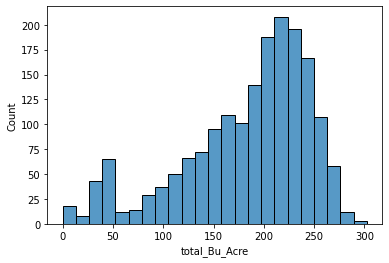

In [283]:
sns.histplot(data=crops, x='total_Bu_Acre')

In [285]:
crops.shape


(1798, 6)

## Ranking Analysis

1.) Quantile Ranking 

    90th perntile - high priority
    
    50th percentile - medium priority
    
    25th percentile- low priority

In [195]:
crops['QRanking_Corn']=np.where(crops['Corn_Yield_Bu_Acre'] >= crops['Corn_Yield_Bu_Acre'].quantile(0.9), 
                           'High Priority',
                          np.where(crops['Corn_Yield_Bu_Acre'] >= crops['Corn_Yield_Bu_Acre'].quantile(0.5), 
                           'Medium Priority',
                                   'Low Priority'))

crops['QRanking_Soy']=np.where(crops['Soybeans_Yield_Bu_Acre'] >= crops['Soybeans_Yield_Bu_Acre'].quantile(0.9), 
                           'High Priority',
                          np.where(crops['Soybeans_Yield_Bu_Acre'] >= crops['Soybeans_Yield_Bu_Acre'].quantile(0.5), 
                           'Medium Priority',
                                   'Low Priority'))

crops['QRanking_Total']=np.where(crops['total_Bu_Acre'] >= crops['total_Bu_Acre'].quantile(0.9), 
                           'High Priority',
                          np.where(crops['total_Bu_Acre'] >= crops['total_Bu_Acre'].quantile(0.5), 
                           'Medium Priority',
                                   'Low Priority'))


In [196]:
crops['total_Bu_Acre'].quantile(0.1)

88.58000000000001

In [197]:
crops.head()

,,Data Item,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre,total_Bu_Acre,QRanking_Corn,QRanking_Soy,QRanking_Total
GEOID,County,State,,,,,,
01001,AUTAUGA,ALABAMA,156.6,0.0,156.6,Low Priority,Low Priority,Low Priority
01003,BALDWIN,ALABAMA,146.8,37.2,184.0,Low Priority,Low Priority,Low Priority
01005,BARBOUR,ALABAMA,151.7,0.0,151.7,Low Priority,Low Priority,Low Priority
01009,BLOUNT,ALABAMA,135.6,47.0,182.6,Low Priority,Medium Priority,Low Priority
01013,BUTLER,ALABAMA,108.2,0.0,108.2,Low Priority,Low Priority,Low Priority


In [198]:
Ranking_Total=crops.groupby(['QRanking_Total','State']).count().reset_index()

In [199]:
Ranking_Total

Data Item,QRanking_Total,State,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre,total_Bu_Acre,QRanking_Corn,QRanking_Soy
0,High Priority,GEORGIA,2,2,2,2,2
1,High Priority,ILLINOIS,45,45,45,45,45
2,High Priority,INDIANA,30,30,30,30,30
3,High Priority,IOWA,11,11,11,11,11
4,High Priority,KANSAS,3,3,3,3,3
...,...,...,...,...,...,...,...
71,Medium Priority,TENNESSEE,44,44,44,44,44
72,Medium Priority,TEXAS,5,5,5,5,5
73,Medium Priority,VIRGINIA,4,4,4,4,4
74,Medium Priority,WASHINGTON,4,4,4,4,4


In [200]:
Ranking_Total[Ranking_Total['QRanking_Total']=='High Priority'].sort_values(by=['total_Bu_Acre'], ascending=False)


Data Item,QRanking_Total,State,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre,total_Bu_Acre,QRanking_Corn,QRanking_Soy
1,High Priority,ILLINOIS,45,45,45,45,45
2,High Priority,INDIANA,30,30,30,30,30
7,High Priority,MINNESOTA,27,27,27,27,27
10,High Priority,NEBRASKA,26,26,26,26,26
3,High Priority,IOWA,11,11,11,11,11
5,High Priority,KENTUCKY,9,9,9,9,9
8,High Priority,MISSISSIPPI,6,6,6,6,6
14,High Priority,WISCONSIN,6,6,6,6,6
11,High Priority,OHIO,5,5,5,5,5
9,High Priority,MISSOURI,4,4,4,4,4


## Join Shp file to CSV - Attribute Join

In [201]:
CropsValue= counties.merge(crops, on='GEOID', how='right')

In [202]:
CropsValue.shape

(1798, 24)

In [203]:
CropsValue.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre,total_Bu_Acre,QRanking_Corn,QRanking_Soy,QRanking_Total
0,01,001,00161526,01001,Autauga,Autauga County,06,H1,G4020,388,33860,None,A,1539634184,25674812,+32.5322367,-086.6464395,"POLYGON ((-86.90310 32.54063, -86.90311 32.540...",156.6,0.0,156.6,Low Priority,Low Priority,Low Priority
1,01,003,00161527,01003,Baldwin,Baldwin County,06,H1,G4020,380,19300,None,A,4117656199,1132956041,+30.6592183,-087.7460666,"POLYGON ((-87.99068 30.55549, -87.99051 30.560...",146.8,37.2,184.0,Low Priority,Low Priority,Low Priority


In [204]:
CropsValue.to_file('data/CropsValue.shp')

Normalized/laundered field name: 'Corn_Yield_Bu_Acre' to 'Corn_Yield'
Normalized/laundered field name: 'Soybeans_Yield_Bu_Acre' to 'Soybeans_Y'
Normalized/laundered field name: 'total_Bu_Acre' to 'total_Bu_A'
Normalized/laundered field name: 'QRanking_Corn' to 'QRanking_C'
Normalized/laundered field name: 'QRanking_Soy' to 'QRanking_S'
Normalized/laundered field name: 'QRanking_Total' to 'QRanking_T'


C:\Users\maria\AppData\Local\Temp/ipykernel_32140/2226256588.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  CropsValue.to_file('data/CropsValue.shp')


# Geocode the facilities

In [205]:
facilities = pd.read_csv('data/indigo_case_study_500_random_buyers.csv')

In [206]:
facilities

,id,latitude,longitude
0,1,37.981011,-101.131373
1,2,38.749860,-93.840057
2,3,42.863391,-95.542792
3,4,32.370266,-89.612160
4,5,39.749561,-86.168043
...,...,...,...
495,496,38.332641,-89.872555
496,497,39.449317,-87.405841
497,498,32.793765,-90.928577
498,499,40.732361,-97.721600


In [207]:
# def make_point(row):
#     return Point(row['longitude'], row['latitude'])


In [208]:
# facilities['geometry']=facilities.apply(make_point, axis=1)

In [209]:
facilities

,id,latitude,longitude
0,1,37.981011,-101.131373
1,2,38.749860,-93.840057
2,3,42.863391,-95.542792
3,4,32.370266,-89.612160
4,5,39.749561,-86.168043
...,...,...,...
495,496,38.332641,-89.872555
496,497,39.449317,-87.405841
497,498,32.793765,-90.928577
498,499,40.732361,-97.721600


In [210]:
# # Map([
# Layer(facilities, 
#       geom_col='geometry', 
#       style=basic_style(opacity=0.75), 
#       popup_hover=popup_element('id'))
    
#     Layer(Corn ,color_bins_style('Value'), encode_data=False)])


In [211]:
# Layer(Corn ,color_bins_style('Value'), encode_data=False)
    

Counties home to farmers that produce the most grain are likely to have more
buyer transactions than lower producing counties

In [212]:
 help(color_bins_style) 

Help on function color_bins_style in module cartoframes.viz.styles.color_bins_style:

color_bins_style(value, method='quantiles', bins=5, breaks=None, palette=None, size=None, opacity=None, stroke_color=None, stroke_width=None, animate=None)
    Helper function for quickly creating a color bins style.
    
    Args:
        value (str): Column to symbolize by.
        method (str, optional): Classification method of data: "quantiles", "equal", "stdev".
            Default is "quantiles".
        bins (int, optional): Number of size classes (bins) for map. Default is 5.
        breaks (list<int>, optional): Assign manual class break values.
        palette (str, optional): Palette that can be a named cartocolor palette
            or other valid color palette. Use `help(cartoframes.viz.palettes)` to
            get more information. Default is "purpor".
        size (int, optional): Size of point or line features.
        opacity (float, optional): Opacity value. Default is 1 for points

In [213]:
facilities_shp= gpd.GeoDataFrame(facilities, geometry=gpd.points_from_xy(facilities.longitude, facilities.latitude),crs='EPSG:4269')

In [214]:
facilities_shp

,id,latitude,longitude,geometry
0,1,37.981011,-101.131373,POINT (-101.13137 37.98101)
1,2,38.749860,-93.840057,POINT (-93.84006 38.74986)
2,3,42.863391,-95.542792,POINT (-95.54279 42.86339)
3,4,32.370266,-89.612160,POINT (-89.61216 32.37027)
4,5,39.749561,-86.168043,POINT (-86.16804 39.74956)
...,...,...,...,...
495,496,38.332641,-89.872555,POINT (-89.87255 38.33264)
496,497,39.449317,-87.405841,POINT (-87.40584 39.44932)
497,498,32.793765,-90.928577,POINT (-90.92858 32.79376)
498,499,40.732361,-97.721600,POINT (-97.72160 40.73236)


In [215]:
facilities_shp.to_file('data/facilities.shp')

# Spatial Join

In [216]:
facilities_shp= gpd.read_file('data/facilities.shp')

In [217]:
facilities_shp.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [218]:
CropsValue.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [219]:
FacilitiesCounties=gpd.sjoin(facilities_shp, CropsValue, how='left', op='within')

In [220]:
FacilitiesCounties

,id,latitude,longitude,geometry,index_right,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Corn_Yield_Bu_Acre,Soybeans_Yield_Bu_Acre,total_Bu_Acre,QRanking_Corn,QRanking_Soy,QRanking_Total
0,1,37.981011,-101.131373,POINT (-101.13137 37.98101),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,38.749860,-93.840057,POINT (-93.84006 38.74986),942.0,29,101,00758505,29101,Johnson,Johnson County,06,H1,G4020,312,47660,None,A,2.147776e+09,10180467.0,+38.7415280,-093.8118634,151.7,47.4,199.1,Low Priority,Medium Priority,Low Priority
2,3,42.863391,-95.542792,POINT (-95.54279 42.86339),389.0,19,035,00465207,19035,Cherokee,Cherokee County,06,H1,G4020,None,None,None,A,1.494181e+09,423160.0,+42.7427375,-095.6332616,186.8,56.1,242.9,Medium Priority,Medium Priority,Medium Priority
3,4,32.370266,-89.612160,POINT (-89.61216 32.37027),885.0,28,123,00695782,28123,Scott,Scott County,06,H1,G4020,None,None,None,A,1.577902e+09,3001523.0,+32.4119595,-089.5334861,0.0,50.3,50.3,Low Priority,Medium Priority,Low Priority
4,5,39.749561,-86.168043,POINT (-86.16804 39.74956),329.0,18,097,00450371,18097,Marion,Marion County,06,H6,G4020,294,26900,None,C,1.027221e+09,16566444.0,+39.7829759,-086.1357939,191.9,0.0,191.9,Medium Priority,Low Priority,Low Priority
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,38.332641,-89.872555,POINT (-89.87255 38.33264),261.0,17,163,01784987,17163,St. Clair,St. Clair County,06,H1,G4020,476,41180,None,A,1.703461e+09,41842145.0,+38.4701976,-089.9285459,163.2,51.7,214.9,Medium Priority,Medium Priority,Medium Priority
496,497,39.449317,-87.405841,POINT (-87.40584 39.44932),363.0,18,167,00450398,18167,Vigo,Vigo County,06,H1,G4020,None,45460,None,A,1.045345e+09,17716575.0,+39.4291426,-087.3903754,176.7,49.3,226.0,Medium Priority,Medium Priority,Medium Priority
497,498,32.793765,-90.928577,POINT (-90.92858 32.79376),886.0,28,125,00695783,28125,Sharkey,Sharkey County,06,H1,G4020,None,None,None,A,1.118150e+09,8806463.0,+32.8923946,-090.8276129,197.7,61.6,259.3,High Priority,High Priority,High Priority
498,499,40.732361,-97.721600,POINT (-97.72160 40.73236),1075.0,31,185,00835914,31185,York,York County,06,H1,G4020,None,None,None,A,1.482794e+09,8595055.0,+40.8730557,-097.5967418,224.6,71.1,295.7,High Priority,High Priority,High Priority


In [221]:
p=FacilitiesCounties.groupby(['QRanking_Total','GEOID'])['id'].count().reset_index()

In [222]:
HP_Total=p[p['QRanking_Total']=='High Priority'].sort_values(by=['id'], ascending=False)
HP_Total=HP_Total.rename(columns={"id":"Count_of_high_Priority_QRT"})

In [223]:
MP_Total=p[p['QRanking_Total']=='Medium Priority'].sort_values(by=['id'], ascending=False)
MP_Total=MP_Total.rename(columns={"id":"Count_of_Medium_Priority_QRT"})
# MP_Total
lP_Total=p[p['QRanking_Total']=='Low Priority'].sort_values(by=['id'], ascending=False)
lP_Total=lP_Total.rename(columns={"id":"Count_of_Low_Priority_QRT"})

In [224]:
All=[MP_Total, lP_Total, HP_Total]

In [225]:
joined=reduce(lambda left, right: pd.merge(left,right, on='GEOID', how='outer'),All)

In [226]:
joined=joined.drop(columns=['QRanking_Total_y','QRanking_Total'])

In [227]:
Count_Faci_Prio_1=counties.merge(joined, on='GEOID', how='right')

In [228]:
Count_Faci_Prio_1

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,QRanking_Total_x,Count_of_Medium_Priority_QRT,Count_of_Low_Priority_QRT,Count_of_high_Priority_QRT
0,19,169,00465273,19169,Story,Story County,06,H1,G4020,218,11180,None,A,1482882553,2862354,+42.0375379,-093.4660934,"POLYGON ((-93.69871 42.03456, -93.69875 42.036...",Medium Priority,5.0,NaN,NaN
1,31,067,00835855,31067,Gage,Gage County,06,H1,G4020,339,13100,None,A,2205273758,22012188,+40.2552337,-096.6834528,"POLYGON ((-96.91629 40.26272, -96.91628 40.262...",Medium Priority,5.0,NaN,NaN
2,19,187,00465282,19187,Webster,Webster County,06,H1,G4020,None,22700,None,A,1853670893,7269394,+42.4335786,-094.1758309,"POLYGON ((-94.39767 42.47330, -94.39772 42.473...",Medium Priority,4.0,NaN,NaN
3,19,167,00465272,19167,Sioux,Sioux County,06,H1,G4020,None,None,None,A,1988888495,2795018,+43.0826460,-096.1780098,"POLYGON ((-96.46602 43.17073, -96.46600 43.170...",Medium Priority,3.0,NaN,NaN
4,18,053,00450355,18053,Grant,Grant County,06,H1,G4020,None,31980,None,A,1072484471,2101804,+40.5157575,-085.6549455,"POLYGON ((-85.86364 40.56553, -85.86366 40.566...",Medium Priority,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,17,071,00424237,17071,Henderson,Henderson County,06,H1,G4020,161,15460,None,A,981068795,42565932,+40.8144710,-090.9412464,"POLYGON ((-91.01390 40.89562, -91.01324 40.896...",NaN,NaN,NaN,1.0
340,17,067,00424235,17067,Hancock,Hancock County,06,H1,G4020,161,22800,None,A,2055798688,53563362,+40.4013180,-091.1688008,"POLYGON ((-91.37421 40.46399, -91.37385 40.464...",NaN,NaN,NaN,1.0
341,27,063,00659477,27063,Jackson,Jackson County,06,H1,G4020,None,None,None,A,1820689892,42120424,+43.6711110,-095.1497314,"POLYGON ((-95.45311 43.67384, -95.45312 43.673...",NaN,NaN,NaN,1.0
342,17,161,00424282,17161,Rock Island,Rock Island County,06,H1,G4020,209,19340,None,A,1107209787,61633885,+41.4684205,-090.5721252,"POLYGON ((-90.33573 41.67043, -90.33554 41.672...",NaN,NaN,NaN,1.0


In [229]:
Count_Faci_Prio.to_file('data/count_faci_prio.shp')

NameError: name 'Count_Faci_Prio' is not defined

In [ ]:
Count_Faci_Prio= gpd.read_file('data/count_faci_prio.shp')

In [ ]:
# Count_Faci_Prio.sort_values(by=['Count_of_high_Priority_QRT'], ascending=False)

# MAPPING

In [414]:
test=Layout([
    Map(
    Layer('count_faci_prio',
         style=color_bins_style('count_of_high_priority_qrt',
         bins=4,
         breaks=[0,2,3,4],
         palette='ag_sunset')),
    
    Layer('facilitiescounties', 
      size_category_style(
          'qranking_total',
          cat=['High Priority', 'Medium Priority', 'Low Priority'],
          size_range=[15,5,3],
          color=('#43f4b6')),
    widgets=[
        basic_widget(
            title='Priority Enrollment Locations',
            description='Faicilites Are prioritize based on yield production totals of corn and soybens',
            footer='Indigo Case Study')])),
        
     Map(Layer('crops_value',
     style=color_bins_style('total_bu_acre',
                           bins=4,
                           palette='mint')))
  
                         ],1,1)

In [ ]:
Map(
   Layer)

In [463]:
Enrollment_Priority_Map=Map([  
    Layer('phase1', title='Phase 1 Area'),
    Layer('count_faci_prio',
           style=color_bins_style('count_of_high_priority_qrt',
            bins= 4,
            breaks=[0,2,3,4],
            palette='cb_blues'),
           title= 'Total High Priority Facilities Per County'),
    Layer('crops_value',
     style=color_bins_style('total_bu_acre',
                           breaks=[200,249.86],
                           palette='mint'),
            legends=color_bins_legend(
            title='Total Yield Bu/Acre*',
            description= '*includes soybeans and corn',
            footer='Data: USDA NASS 2020'), 
            title='Total Grain Yield'),
     Layer('facilitiescounties', 
      size_category_style(
          'qranking_total',
          cat=['High Priority', 'Medium Priority', 'Low Priority'],
          size_range=[25,15,3],
          color=('#43f4b6')),
      legends=size_category_legend(title='Priority Category'),
    popup_hover=[popup_element('id','Facility ID'),
                 popup_element('namelsad','County Name'),
                 popup_element('qranking_total','Priority Ranking'),
                 popup_element('geoid','GEOID')],
    widgets=[
        basic_widget(
            title='Priority Enrollment Locations',
            description='Faicilites are prioritize based on yield production totals of corn and soybeans',
            footer='Indigo Case Study'),
        category_widget('qranking_total',
                            title='Priority Category',
                            description='Select to Filter the priority category                        ' 
                        '*NaNs are facilities located in a county that dos not produce the specificed grains',
                            read_only=False),
        basic_widget(
    title= 'Phase 1 Area Enrollment',
    description=' Click to turn off layers and see Phase 1 Area', 
    footer='The recommendated high priority cluster location that the marketplace team show focus on'),
     basic_widget(
           footer='To Explore how priority categories and Phase 1 Area were defined : <a href="https://github.com/mariamartz/Interview">Github</a>')],
                             
    title='Total Grain Yield Facility Priority'),
                             
    ],
   layer_selector=True)

In [459]:
Enrollment_Priority_Map

In [ ]:
test

In [271]:
test2=Layout([
    Map(Layer('count_faci_prio',
         style=color_bins_style('count_of_h',
         bins=4,
         breaks=[1,2,4],
         palette='cb_blues'))),
    
    Map([Layer('crops_value',
     style=color_bins_style('total_bu_acre',
                           breaks=[200,249.86],
                           palette='mint'),
            legends=color_bins_legend(
            title='Total Yield Bu/Acre*',
            description= '*includes soybeans and corn',
            footer='Data: USDA NASS 2020'), 
            title='Total Grain Yield'),
         
        Layer('facilitiescounties', 
      size_category_style(
          'qranking_total',
          cat=['High Priority', 'Medium Priority', 'Low Priority'],
          size_range=[25,15,3],
          color=('#43f4b6')),
      legends=size_category_legend(title='Priority Category'),
    popup_hover=[popup_element('id','Facility ID'),
                 popup_element('namelsad','County Name')],
    widgets=[basic_widget(
            title='Priority Enrollment Locations',
            description='Faicilites Are prioritize based on yield production totals of corn and soybeans',
            footer='Indigo Case Study')])])],1,2)

In [272]:
#  help(size_category_style) 

In [273]:
test2

In [ ]:
#  help(color_bins_style) 

In [464]:
Enrollment_Priority_Map.publish('Enrollment_Priority_map', password=None, if_exists='replace')


{'id': 'e8aa1427-1f33-4682-bba8-4ff03ba86e7c',
 'url': 'https://mariana11martz11.carto.com/kuviz/e8aa1427-1f33-4682-bba8-4ff03ba86e7c',
 'name': 'Enrollment_Priority_map',
 'privacy': 'public'}

In [259]:
Crop Production.publish('test2', password=123, if_exists='replace')

{'id': '4ffe78b2-5c44-40db-ae3a-d64c4dd448e6',
 'url': 'https://mariana11martz11.carto.com/kuviz/4ffe78b2-5c44-40db-ae3a-d64c4dd448e6',
 'name': 'test2',
 'privacy': 'public'}

In [ ]:
# help(basic_widget)

In [ ]:
help(palettes)

In [ ]:
to_carto(FacilitiesCounties, 'facilitiescounties', if_exists='replace')

In [ ]:
to_carto(Count_Faci_Prio_1, 'Count_Faci_Prio_1', if_exists='replace')

In [ ]:
to_carto(CropsValue, 'crops_value', if_exists='replace')

In [449]:
to_carto(phase1,'phase1',if_exists='replace')

Success! Data uploaded to table "phase1" correctly


'phase1'

In [ ]:
help(color_category_style)

In [ ]:
help(formula_widget)

In [ ]:
help(Popup)

In [ ]:
help(color_bins_legend)

## Extra Extra

In [ ]:
import pysal as ps

In [ ]:
LMCoun=ps.Moran_Local()

In [274]:
help(Layout)

Help on class Layout in module cartoframes.viz.layout:

class Layout(builtins.object)
 |  Layout(maps, n_size=None, m_size=None, viewport=None, map_height=250, full_height=True, is_static=False, **kwargs)
 |  
 |  Create a layout of visualizations in order to compare them.
 |  
 |  Args:
 |      maps (list of :py:class:`Map <cartoframes.viz.Map>`): List of
 |          maps. Zero or more of :py:class:`Map <cartoframes.viz.Map>`.
 |      n_size (number, optional): Number of columns of the layout
 |      m_size (number, optional): Number of rows of the layout
 |      viewport (dict, optional): Properties for display of the maps viewport.
 |          Keys can be `bearing` or `pitch`.
 |      is_static (boolean, optional): By default is False. All the maps in each visualization
 |          are interactive. In order to set them static images for performance reasons
 |          set `is_static` to True.
 |      map_height (number, optional): Height in pixels for each visualization.
 |         

In [380]:
Phase1=['17143','17179','17125','17107','17147','17019','17137','17113','17021']

In [381]:
Phase1_counties_filter=counties[counties['GEOID'].isin(Phase1)]

In [382]:
Phase1_counties_filter

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
148,17,113,01784833,17113,McLean,McLean County,06,H1,G4020,145,14010,None,A,3064597287,7804856,+40.4945594,-088.8445391,"POLYGON ((-89.26650 40.48555, -89.26653 40.486..."
254,17,147,00424275,17147,Piatt,Piatt County,06,H1,G4020,None,16580,None,A,1137492089,754122,+40.0090327,-088.5923546,"POLYGON ((-88.74516 40.05519, -88.74516 40.055..."
1302,17,125,00424261,17125,Mason,Mason County,06,H1,G4020,None,None,None,A,1396914848,62748513,+40.2369926,-089.9135746,"POLYGON ((-90.11492 40.24548, -90.11318 40.250..."
1852,17,179,01785094,17179,Tazewell,Tazewell County,06,H1,G4020,None,37900,None,A,1674347384,29807343,+40.5080743,-089.5162598,"POLYGON ((-89.61606 40.66076, -89.61607 40.661..."
1956,17,137,00424270,17137,Morgan,Morgan County,06,H1,G4020,522,27300,None,A,1473567808,9081549,+39.7176678,-090.2050054,"POLYGON ((-90.37195 39.71676, -90.37193 39.717..."
2534,17,107,00424255,17107,Logan,Logan County,06,H1,G4020,522,30660,None,A,1600748259,2262329,+40.1292768,-089.3653086,"POLYGON ((-89.37737 40.32412, -89.37541 40.324..."
2611,17,143,01784920,17143,Peoria,Peoria County,06,H1,G4020,None,37900,None,A,1602499827,30699174,+40.7859722,-089.7669933,"POLYGON ((-89.98533 40.80007, -89.98533 40.800..."
2620,17,019,00424211,17019,Champaign,Champaign County,06,H1,G4020,None,16580,None,A,2579896781,6111775,+40.1389845,-088.1969749,"POLYGON ((-88.46317 40.14220, -88.46322 40.143..."
2685,17,021,00424212,17021,Christian,Christian County,06,H1,G4020,522,45380,None,A,1837569687,16227346,+39.5455242,-089.2795927,"POLYGON ((-89.25528 39.81472, -89.25524 39.814..."


In [383]:
phase1=gpd.overlay(Phase1_counties_filter,Phase1_counties_filter, how='union')

C:\Users\maria\AppData\Local\Temp/ipykernel_32140/3783557014.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  phase1=gpd.overlay(Phase1_counties_filter,Phase1_counties_filter, how='union')


In [384]:
phase1

,STATEFP_1,COUNTYFP_1,COUNTYNS_1,GEOID_1,NAME_1,NAMELSAD_1,LSAD_1,CLASSFP_1,MTFCC_1,CSAFP_1,CBSAFP_1,METDIVFP_1,FUNCSTAT_1,ALAND_1,AWATER_1,INTPTLAT_1,INTPTLON_1,STATEFP_2,COUNTYFP_2,COUNTYNS_2,GEOID_2,NAME_2,NAMELSAD_2,LSAD_2,CLASSFP_2,MTFCC_2,CSAFP_2,CBSAFP_2,METDIVFP_2,FUNCSTAT_2,ALAND_2,AWATER_2,INTPTLAT_2,INTPTLON_2,geometry
0,17,113,01784833,17113,McLean,McLean County,06,H1,G4020,145,14010,None,A,3064597287,7804856,+40.4945594,-088.8445391,17,113,01784833,17113,McLean,McLean County,06,H1,G4020,145,14010,None,A,3064597287,7804856,+40.4945594,-088.8445391,"POLYGON ((-89.26653 40.48647, -89.26657 40.488..."
1,17,147,00424275,17147,Piatt,Piatt County,06,H1,G4020,None,16580,None,A,1137492089,754122,+40.0090327,-088.5923546,17,147,00424275,17147,Piatt,Piatt County,06,H1,G4020,None,16580,None,A,1137492089,754122,+40.0090327,-088.5923546,"POLYGON ((-88.74516 40.05528, -88.74517 40.055..."
2,17,179,01785094,17179,Tazewell,Tazewell County,06,H1,G4020,None,37900,None,A,1674347384,29807343,+40.5080743,-089.5162598,17,179,01785094,17179,Tazewell,Tazewell County,06,H1,G4020,None,37900,None,A,1674347384,29807343,+40.5080743,-089.5162598,"POLYGON ((-89.61607 40.66105, -89.61579 40.662..."
3,17,107,00424255,17107,Logan,Logan County,06,H1,G4020,522,30660,None,A,1600748259,2262329,+40.1292768,-089.3653086,17,107,00424255,17107,Logan,Logan County,06,H1,G4020,522,30660,None,A,1600748259,2262329,+40.1292768,-089.3653086,"POLYGON ((-89.37541 40.32417, -89.37510 40.324..."
4,17,019,00424211,17019,Champaign,Champaign County,06,H1,G4020,None,16580,None,A,2579896781,6111775,+40.1389845,-088.1969749,17,019,00424211,17019,Champaign,Champaign County,06,H1,G4020,None,16580,None,A,2579896781,6111775,+40.1389845,-088.1969749,"POLYGON ((-88.46322 40.14318, -88.46323 40.144..."
5,17,125,00424261,17125,Mason,Mason County,06,H1,G4020,None,None,None,A,1396914848,62748513,+40.2369926,-089.9135746,17,125,00424261,17125,Mason,Mason County,06,H1,G4020,None,None,None,A,1396914848,62748513,+40.2369926,-089.9135746,"POLYGON ((-90.11318 40.25004, -90.11087 40.255..."
6,17,143,01784920,17143,Peoria,Peoria County,06,H1,G4020,None,37900,None,A,1602499827,30699174,+40.7859722,-089.7669933,17,143,01784920,17143,Peoria,Peoria County,06,H1,G4020,None,37900,None,A,1602499827,30699174,+40.7859722,-089.7669933,"POLYGON ((-89.98533 40.80012, -89.98533 40.800..."
7,17,137,00424270,17137,Morgan,Morgan County,06,H1,G4020,522,27300,None,A,1473567808,9081549,+39.7176678,-090.2050054,17,137,00424270,17137,Morgan,Morgan County,06,H1,G4020,522,27300,None,A,1473567808,9081549,+39.7176678,-090.2050054,"POLYGON ((-90.37193 39.71744, -90.37183 39.722..."
8,17,021,00424212,17021,Christian,Christian County,06,H1,G4020,522,45380,None,A,1837569687,16227346,+39.5455242,-089.2795927,17,021,00424212,17021,Christian,Christian County,06,H1,G4020,522,45380,None,A,1837569687,16227346,+39.5455242,-089.2795927,"POLYGON ((-89.25524 39.81477, -89.25516 39.814..."


In [385]:
Layer(phase1)